In [27]:
!pip install numpy pandas plotly scikit-learn

Defaulting to user installation because normal site-packages is not writeable


## Whole Process

Dataset Overview

The COMPAS dataset contains records from Broward County, Florida.

Total size: 7,214 individual defendant records

Two-year follow-up period for recidivism tracking

* Detailed Record Contents

Demographic Information:

Age: Ranges from 18-96 years, grouped into categories

Gender: Male/Female

Race: African-American (51%), Caucasian (34%), Hispanic (8%), Other (7%)

Marital Status

Citizenship Status

* Criminal History:

Number of prior arrests (ranging 0-38)

Prior conviction counts

Charge degree (misdemeanor/felony)

Charge description

Violence flag for current charge

Prior juvenile felony count

Prior juvenile misdemeanor count

* Risk Assessment:

COMPAS Risk Scores (scale 1-10):

Recidivism Risk Score
Violent Recidivism Risk Score
Failure to Appear Risk Score"

Risk Categories:

Low Risk (1-4)
Medium Risk (5-7)
High Risk (8-10)"


* Outcome Variables:

Two-year recidivism flag (yes/no)
Time to recidivism (in days)
Type of recidivism offense
Arrest date for recidivism


* Initial Bias Statistics Example

False Positive Rates by Race:

African-American defendants: 45%
Caucasian defendants: 23%
Hispanic defendants: 30%"


Risk Score Distribution:

African-American defendants more likely to be classified as high-risk (31%)
Caucasian defendants less likely to be classified as high-risk (18%)


## DCA Solution Workflow:

# 1. Data Processing Phase:

* Raw COMPAS Data

Input: Original COMPAS scores, defendant demographics, and outcomes

Why: Starting point for bias correction


* Standardize Race Categories

What: Converts diverse racial labels into consistent categories

Why: Ensures reliable demographic analysis

How: Maps to six standard categories (African-American, Caucasian, Hispanic, Asian, Native American, Other)

* Normalize Scores

What: Converts COMPAS decile scores (1-10) to 0-100 scale

Why: Creates consistent scale where higher numbers mean lower risk

How: Inverts and normalizes original scores


* Create Individual Objects

What: Structures data into Individual class instances

Why: Organizes data for consistent processing

How: Combines normalized scores with demographic data


# 2. DCA Initialization Phase:

* Calculate Initial Disparities

What: Measures baseline racial disparities in risk assessments

Why: Establishes starting point for bias correction

How: Compares risk distributions across racial groups


* Initialize Bonus Vector

What: Creates initial bias correction values

Why: Starting point for optimization

How: Based on observed disparities


# 3. Core DCA Process:

* Sample Defendants

What: Randomly selects subset of cases

Why: Makes computation manageable and prevents overfitting

How: Uses fixed sample size with randomization


* Calculate Adjusted Scores

What: Applies bias corrections to risk scores

Why: Compensates for racial disparities

How: Combines original scores with bonus points


* Select Top K%

What: Identifies lowest-risk individuals after adjustment

Why: Simulates decision-making process

How: Selects based on adjusted scores


* Measure Racial Disparities

What: Evaluates remaining bias after adjustments

Why: Tracks progress of bias reduction

How: Compares demographic distributions


* Update Bonus Vector

What: Adjusts compensation values

Why: Iteratively reduces disparities

How: Uses gradient-based updates with momentum


# 4. Refinement Phase:

* Adam Optimization

What: Fine-tunes bonus values

Why: Improves final results

How: Uses adaptive moment estimation


# 5. Final Metrics

What: Calculates performance measures

Why: Evaluates success of bias correction

How: Measures disparity reduction and score stability


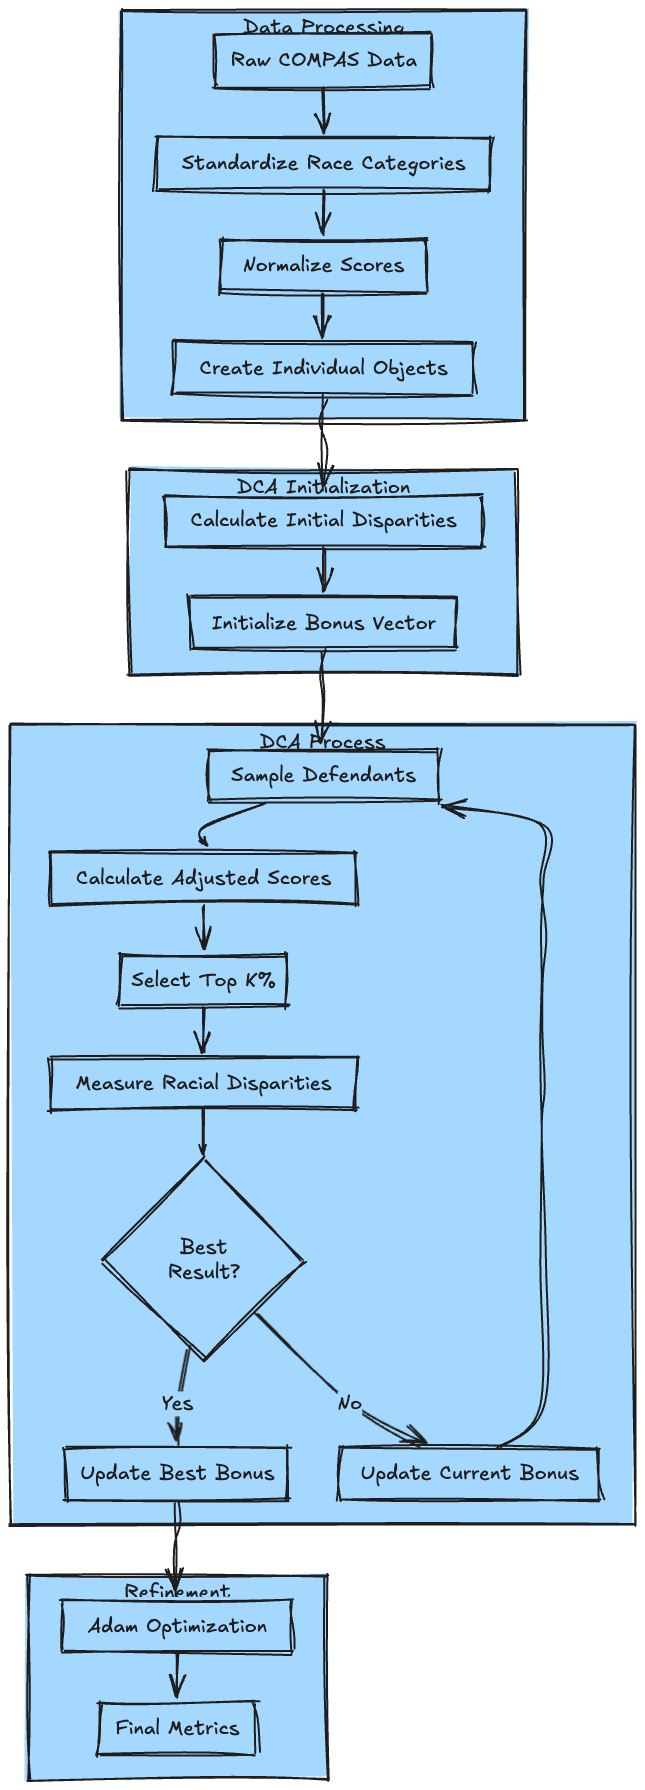

In [28]:
%%writefile compas_core.py

# In compas_core.py

import numpy as np
import logging
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import math

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set random seeds
np.random.seed(42)
random.seed(42)

@dataclass
class Individual:
    """Individual class to hold COMPAS defendant data"""
    """
    What: Represents a defendant in the COMPAS dataset
    Why: To structure defendant data and compute fairness attributes
    Result: Creates standardized individual records with racial fairness indicators
    """
    
    id: int
    decile_score: float  # COMPAS decile score (1-10)
    base_score: float    # Normalized base score (0-100)
    is_recid: bool      # Whether actually reoffended
    race: str           # Race/ethnicity
    age: str           # Age category
    sex: str           # Gender
    priors_count: int  # Number of prior offenses
    c_charge_degree: str  # Charge degree (F/M)

    @property
    def fairness_attributes(self) -> np.ndarray:
        """Return array of fairness attributes focused on race"""
        """
        What: Converts race into binary indicator vectors
        Why: To enable mathematical operations on demographic attributes
        Result: Returns a 6-dimensional vector encoding racial category
        """
        # Map race to binary indicators
        race_mapping = {
            'African-American': [1, 0, 0, 0, 0, 0],
            'Caucasian': [0, 1, 0, 0, 0, 0],
            'Hispanic': [0, 0, 1, 0, 0, 0],
            'Asian': [0, 0, 0, 1, 0, 0],
            'Native American': [0, 0, 0, 0, 1, 0],
            'Other': [0, 0, 0, 0, 0, 1]
        }
        # Default to 'Other' if race not in mapping
        return np.array(race_mapping.get(self.race, race_mapping['Other']))

class CompasDataProcessor:
    """Process and normalize COMPAS data"""
    """
    What: Processes raw COMPAS recidivism data
    Why: To standardize and normalize input data for the DCA algorithm
    Result: Produces clean, normalized dataset for analysis
    """
    
    def __init__(self):
        self.race_categories = [
            'African-American', 'Caucasian', 'Hispanic', 
            'Asian', 'Native American', 'Other'
        ]
        
    def normalize_score(self, decile_score: int) -> float:
        """Convert decile score (1-10) to normalized score (0-100)"""
        """
        What: Converts COMPAS decile scores (1-10) to normalized scores (0-100)
        Why: To create consistent scale where higher scores are better
        Result: Returns normalized score where 100 = lowest risk, 0 = highest risk
        """
        return ((10 - decile_score) / 9) * 100  # Invert so lower risk = higher score

    def standardize_race(self, race: str) -> str:
        """Standardize race categories"""
        """
        What: Standardizes racial categories into fixed set
        Why: To ensure consistent demographic categorization
        Result: Returns standardized race label from predefined categories
        """
    
        race = str(race).strip()
        race_map = {
            'African-American': 'African-American',
            'Caucasian': 'Caucasian',
            'Hispanic': 'Hispanic',
            'Asian': 'Asian',
            'Native American': 'Native American',
            'Other': 'Other'
        }
        return race_map.get(race, 'Other')

    def process_data(self, data: List[Dict]) -> List[Individual]:
        """Process raw COMPAS data into Individual objects"""
        """
        What: Converts raw data into structured Individual objects
        Why: To create clean, typed dataset for analysis
        Result: Returns list of properly formatted Individual instances
        """
        individuals = []
        
        for i, row in enumerate(data):
            try:
                # Standardize race
                race = self.standardize_race(row['race'])
                
                # Process score
                decile_score = float(row['decile_score'])
                base_score = self.normalize_score(decile_score)
                
                individual = Individual(
                    id=i,
                    decile_score=decile_score,
                    base_score=base_score,
                    is_recid=bool(int(row['is_recid'])),
                    race=race,
                    age=str(row['age_cat']),
                    sex=str(row['sex']),
                    priors_count=int(row['priors_count']),
                    c_charge_degree=str(row['c_charge_degree'])
                )
                individuals.append(individual)
                
            except (ValueError, KeyError) as e:
                logger.warning(f"Error processing row {i}: {e}")
                continue
                
        return individuals

class DCA:
    """Disparity Compensation Algorithm Implementation for COMPAS data"""
    
    def __init__(
        self,
        learning_rates: Optional[List[float]] = None,
        num_iterations: int = 100,
        sample_size: int = 500,
        granularity: float = 0.5,
        max_bonus_points: float = 20.0
    ):
        self.learning_rates = learning_rates or [1.0, 0.5, 0.1]
        self.num_iterations = num_iterations
        self.sample_size = sample_size
        self.granularity = granularity
        self.max_bonus_points = max_bonus_points
        self.num_fairness_attributes = 6  # Number of race categories
        
        self.disparity_history = []
        self.bonus_history = []

    def calculate_centroid(self, objects: List[Individual]) -> np.ndarray:
        """Calculate centroid of fairness attributes"""
        """
        What: Calculates average racial composition of a group
        Why: To measure demographic representation
        Result: Returns vector of mean proportions for each racial category
        """
        if not objects:
            return np.zeros(self.num_fairness_attributes)
        fairness_attrs = np.array([obj.fairness_attributes for obj in objects])
        return np.mean(fairness_attrs, axis=0)

    def calculate_scores(self, objects: List[Individual], bonus_vector: np.ndarray) -> np.ndarray:
        """Calculate scores with bonus points applied"""
        """
        What: Computes risk scores with racial bias compensation
        Why: To adjust risk assessments for racial disparities
        Result: Returns adjusted risk scores (lower is better for COMPAS)
        Note: Inverts bonus points since lower scores are better
        """
        if not objects:
            return np.array([])
            
        # For COMPAS, lower scores are better, so we invert the bonus points
        base_scores = np.array([obj.base_score for obj in objects])
        bonus_scores = np.array([np.dot(obj.fairness_attributes, -bonus_vector) for obj in objects])
        return base_scores + bonus_scores

    def select_top_k_percent(self, objects: List[Individual], scores: np.ndarray, k: float) -> List[Individual]:
        """Select top k% of objects based on scores (lower is better for COMPAS)"""
        """
        What: Selects lowest-risk individuals based on adjusted scores
        Why: To simulate risk-based decision making
        Result: Returns list of k% lowest-risk individuals
        """
        if not objects or k <= 0:
            return []
        num_to_select = max(1, int(len(objects) * k))
        indices = np.argsort(scores)[:num_to_select]  # Lower scores are better
        return [objects[i] for i in indices]

    def calculate_disparity(self, objects: List[Individual], k: float, bonus_vector: np.ndarray) -> np.ndarray:
        """Calculate disparity following paper Definition 3"""
        """
        What: Measures racial disparities in selection outcomes
        Why: To quantify effectiveness of bias compensation
        Result: Returns vector of differences between selected and overall racial composition
        """
        if not objects:
            return np.zeros(self.num_fairness_attributes)
            
        D_O = self.calculate_centroid(objects)
        scores = self.calculate_scores(objects, bonus_vector)
        selected = self.select_top_k_percent(objects, scores, k)
        D_k = self.calculate_centroid(selected)
        
        return D_k - D_O

    def initialize_bonus_vector(self, objects: List[Individual], k: float) -> np.ndarray:
        """Initialize bonus vector based on initial disparities"""
        """
        What: Creates initial compensation values for each racial category
        Why: To start optimization with reasonable bias corrections
        Result: Returns initial bonus vector based on observed disparities
        """
        initial_disparity = self.calculate_disparity(objects, k, np.zeros(self.num_fairness_attributes))
        initial_bonus = -initial_disparity * 10.0  # Larger initial bonus scaling factor
        return np.clip(initial_bonus, 0, self.max_bonus_points)

    def update_bonus_vector(self, current_B: np.ndarray, D_k: np.ndarray, 
                         learning_rate: float, iteration: int) -> np.ndarray:
        """Update bonus vector with momentum"""
        """
        What: Adjusts compensation values based on observed disparities
        Why: To iteratively reduce racial bias in risk assessments
        Result: Returns updated bonus vector with momentum and constraints
        """
        momentum = min(0.9, iteration / 100)
        gradient = -D_k * (1 - momentum)  # Negative since we want to compensate disparities
        new_B = current_B + learning_rate * gradient  # Add since we want to increase bonus where disparity exists
        new_B = np.clip(new_B, 0, self.max_bonus_points)
        return np.round(new_B / self.granularity) * self.granularity

    def run_adam_refinement(self, objects: List[Individual], k: float, B_initial: np.ndarray) -> np.ndarray:
        """Refinement step using Adam optimizer"""
        """
        What: Fine-tunes compensation values using Adam optimizer
        Why: To improve final results with advanced optimization
        Result: Returns refined bonus vector with minimal disparities
        """
        beta1, beta2 = 0.9, 0.999
        epsilon = 1e-8
        learning_rate = 0.001
        
        m = np.zeros_like(B_initial)
        v = np.zeros_like(B_initial)
        B = B_initial.copy()
        
        best_B = B.copy()
        best_disparity = float('inf')
        
        for t in range(1, self.num_iterations + 1):
            sample = random.sample(objects, min(len(objects), self.sample_size * 2))
            D_k = self.calculate_disparity(sample, k, B)
            disparity_norm = float(np.linalg.norm(D_k))
            
            if disparity_norm < best_disparity:
                best_disparity = disparity_norm
                best_B = B.copy()
            
            # Update in opposite direction of disparity
            m = beta1 * m + (1 - beta1) * (-D_k)
            v = beta2 * v + (1 - beta2) * np.square(D_k)
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            
            B = B + learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
            B = np.clip(B, 0, self.max_bonus_points)
        
        return np.round(best_B / self.granularity) * self.granularity

    def run(self, objects: List[Individual], k: float) -> Tuple[np.ndarray, Dict]:
        """Complete DCA pipeline for COMPAS data"""
        """
        What: Executes complete DCA pipeline for COMPAS data
        Why: To find optimal bias compensation values
        Result: Returns:
            1. Final bonus vector for racial bias compensation
            2. Dictionary of performance metrics including:
               - Disparity history
               - Bonus history
               - Final disparity norm
        Process:
            1. Initialize compensation
            2. Iterative optimization with multiple learning rates
            3. Final refinement with Adam
            4. Metric calculation
        """
        B = self.initialize_bonus_vector(objects, k)
        best_B = B.copy()
        best_disparity_norm = float('inf')
        
        for learning_rate in self.learning_rates:
            logger.info(f"Starting iterations with learning rate {learning_rate}")
            
            for iteration in range(self.num_iterations):
                sample = random.sample(objects, min(len(objects), self.sample_size))
                D_k = self.calculate_disparity(sample, k, B)
                disparity_norm = float(np.linalg.norm(D_k))
                
                if disparity_norm < best_disparity_norm:
                    best_disparity_norm = disparity_norm
                    best_B = B.copy()
                
                B = self.update_bonus_vector(B, D_k, learning_rate, iteration)
                
                self.disparity_history.append(disparity_norm)
                self.bonus_history.append(B.copy())
                
                if iteration % 10 == 0:
                    logger.info(f"Iteration {iteration}, Disparity norm: {disparity_norm:.4f}")
        
        logger.info("Starting DCA Refinement")
        final_B = self.run_adam_refinement(objects, k, best_B)
        
        # Calculate final disparity
        final_disparity = self.calculate_disparity(objects, k, final_B)
        final_disparity_norm = float(np.linalg.norm(final_disparity))
        
        metrics = {
            'disparity_history': self.disparity_history,
            'bonus_history': self.bonus_history,
            'final_disparity_norm': final_disparity_norm
        }
        
        logger.info(f"Final bonus vector: {final_B}")
        logger.info(f"Final disparity norm: {metrics['final_disparity_norm']:.4f}")
        
        return final_B, metrics

Overwriting compas_core.py


In [29]:
%%writefile compas_visualization.py

import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from typing import List, Dict, Tuple, Optional
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class ExtendedCompassMetrics:
    """Extended evaluation metrics for COMPAS fairness assessment"""
    
    @staticmethod
    def calculate_ndcg(original_scores: np.ndarray, new_scores: np.ndarray, k: float) -> float:
        """Calculate normalized discounted cumulative gain"""
        def dcg(scores: np.ndarray, k: float) -> float:
            if len(scores) == 0:
                return 0.0
            n = max(1, int(len(scores) * k))
            top_scores = np.sort(scores)[-n:][::-1]
            gains = 2 ** top_scores - 1
            discounts = np.log2(np.arange(2, len(gains) + 2))
            return np.sum(gains / discounts)

        dcg_new = dcg(new_scores, k)
        dcg_ideal = dcg(original_scores, k)
        
        return dcg_new / dcg_ideal if dcg_ideal > 0 else 1.0

    @staticmethod
    def calculate_false_positive_rate(y_true: np.ndarray, predictions: np.ndarray, group_mask: np.ndarray) -> float:
        """Calculate False Positive Rate for a specific group"""
        # Focus on cases that didn't reoffend
        negative_cases = y_true == 0
        # Filter for specific group and negative cases
        group_negatives = np.logical_and(group_mask, negative_cases)
        
        if np.sum(group_negatives) == 0:
            return 0.0
            
        # Calculate FPR
        false_positives = np.sum(np.logical_and(group_negatives, predictions == 1))
        return false_positives / np.sum(group_negatives)

    @staticmethod
    def calculate_exposure(ranking: np.ndarray, group_membership: np.ndarray) -> float:
        """Calculate exposure metric following paper VI.C.4"""
        if len(ranking) == 0:
            return 0.0
        
        positions = np.arange(1, len(ranking) + 1)
        exposure_weights = 1.0 / np.log2(positions + 1)
        
        group_exposure = np.sum(exposure_weights[group_membership])
        group_size = np.sum(group_membership)
        
        return group_exposure / group_size if group_size > 0 else 0.0

    @staticmethod
    def calculate_group_disparities(
        selected: List,
        overall: List,
        attributes: List[str]
    ) -> Tuple[Dict[str, float], float]:
        """Calculate disparity metrics for selected vs overall population"""
        if not selected or not overall:
            return {attr: 0.0 for attr in attributes}, 0.0
            
        disparities = {}
        
        # Calculate disparities for each race attribute
        for attr in attributes:
            selected_count = sum(1.0 if s.race == attr else 0.0 for s in selected)
            overall_count = sum(1.0 if s.race == attr else 0.0 for s in overall)
            
            selected_mean = selected_count / len(selected) if selected else 0.0
            overall_mean = overall_count / len(overall) if overall else 0.0
            
            disparities[attr] = float(selected_mean - overall_mean)
        
        # Calculate disparity norm
        disparity_vector = np.array([disparities[attr] for attr in attributes])
        disparity_norm = float(np.linalg.norm(disparity_vector))
        
        return disparities, disparity_norm

class CompasVisualizer:
    """Create interactive visualizations for COMPAS fairness analysis"""
    
    def __init__(self):
        self.metrics = ExtendedCompassMetrics()
        self.race_colors = {
            'African-American': 'rgb(141,211,199)',
            'Caucasian': 'rgb(255,255,179)', 
            'Hispanic': 'rgb(190,186,218)',
            'Asian': 'rgb(251,128,114)',
            'Native American': 'rgb(128,177,211)',
            'Other': 'rgb(253,180,98)'
        }
    
    def plot_convergence(self, 
                        iterations: List[int],
                        disparity_history: List[float],
                        bonus_history: List[np.ndarray]) -> go.Figure:
        """Create convergence plot showing disparity reduction progress"""
        fig = make_subplots(
            rows=2, cols=1,
            subplot_titles=('Disparity Norm Over Iterations', 'Bonus Points Evolution')
        )
        
        # Plot disparity convergence
        fig.add_trace(
            go.Scatter(x=iterations, y=disparity_history,
                      mode='lines', name='Disparity Norm',
                      line=dict(color='royalblue')),
            row=1, col=1
        )
        
        # Plot bonus points evolution
        bonus_history = np.array(bonus_history)
        races = ['African-American', 'Caucasian', 'Hispanic', 'Asian', 'Native American', 'Other']
        
        for i, race in enumerate(races):
            fig.add_trace(
                go.Scatter(x=iterations, y=bonus_history[:, i],
                          mode='lines', name=f'{race} Bonus',
                          line=dict(color=self.race_colors[race])),
                row=2, col=1
            )
        
        fig.update_layout(
            height=800,
            showlegend=True,
            title_text="DCA Convergence Analysis for COMPAS Data",
            template='plotly_white'
        )
        
        return fig

    def plot_fairness_metrics(self,
                            k_values: List[float],
                            disparities: List[float],
                            ndcg_values: List[float],
                            fpr_values: Optional[Dict[str, List[float]]] = None) -> go.Figure:
        """Create fairness metrics plot showing disparities and NDCG"""
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        
        # Add disparity trace
        fig.add_trace(
            go.Scatter(x=k_values, y=disparities,
                      name="Disparity Norm",
                      mode='lines+markers',
                      line=dict(color='royalblue')),
            secondary_y=False
        )
        
        # Add NDCG trace
        fig.add_trace(
            go.Scatter(x=k_values, y=ndcg_values,
                      name="NDCG",
                      mode='lines+markers',
                      line=dict(color='firebrick')),
            secondary_y=True
        )
        
        # Add FPR traces if provided
        if fpr_values is not None:
            for race, fpr_list in fpr_values.items():
                fig.add_trace(
                    go.Scatter(x=k_values, y=fpr_list,
                              name=f"FPR {race}",
                              mode='lines+markers',
                              line=dict(color=self.race_colors[race],
                                      dash='dash')),
                    secondary_y=True
                )
        
        fig.update_layout(
            title='Fairness-Utility Tradeoff Analysis for COMPAS',
            xaxis_title='Selection Size (k)',
            template='plotly_white',
            hovermode='x unified'
        )
        
        fig.update_yaxes(title_text="Disparity Norm", secondary_y=False)
        fig.update_yaxes(title_text="NDCG / FPR", secondary_y=True)
        
        return fig

    def plot_race_disparities(self,
                            k_values: List[float],
                            group_disparities: Dict[str, List[float]]) -> go.Figure:
        """Plot disparities by race group"""
        fig = go.Figure()
        
        for race, disparities in group_disparities.items():
            fig.add_trace(
                go.Scatter(x=k_values, y=disparities,
                          name=race,
                          mode='lines+markers',
                          line=dict(color=self.race_colors[race]))
            )
        
        fig.update_layout(
            title='Race-wise Disparities in COMPAS Predictions',
            xaxis_title='Selection Size (k)',
            yaxis_title='Disparity',
            template='plotly_white',
            hovermode='x unified'
        )
        
        return fig

    def create_report_visualizations(
        self,
        dca,
        individuals: List,
        bonus_vector: np.ndarray,
        training_metrics: Dict,
        k: float
    ) -> Dict[str, go.Figure]:
        """Create all visualizations for the report"""
        # Prepare data for plots
        iterations = list(range(len(training_metrics['disparity_history'])))
        k_values = np.linspace(0.05, 0.5, 10)
        
        # Calculate metrics across k values
        disparities = []
        ndcgs = []
        group_disparities = {race: [] for race in self.race_colors.keys()}
        fpr_values = {race: [] for race in self.race_colors.keys()}
        
        original_scores = np.array([ind.base_score for ind in individuals])
        new_scores = dca.calculate_scores(individuals, bonus_vector)
        
        for k_val in k_values:
            # Calculate disparity
            disparity = dca.calculate_disparity(individuals, k_val, bonus_vector)
            disparities.append(float(np.linalg.norm(disparity)))
            
            # Calculate NDCG
            ndcg = self.metrics.calculate_ndcg(original_scores, new_scores, k_val)
            ndcgs.append(ndcg)
            
            # Calculate group disparities
            selected = dca.select_top_k_percent(individuals, new_scores, k_val)
            for race in self.race_colors.keys():
                selected_prop = np.mean([1.0 if s.race == race else 0.0 for s in selected])
                overall_prop = np.mean([1.0 if s.race == race else 0.0 for s in individuals])
                group_disparities[race].append(selected_prop - overall_prop)
                
                # Calculate FPR for each race
                predictions = np.zeros(len(individuals))
                predictions[np.argsort(new_scores)[-int(len(individuals) * k_val):]] = 1
                group_mask = np.array([s.race == race for s in individuals])
                y_true = np.array([s.is_recid for s in individuals])
                fpr = self.metrics.calculate_false_positive_rate(y_true, predictions, group_mask)
                fpr_values[race].append(fpr)
        
        return {
            'convergence': self.plot_convergence(
                iterations, 
                training_metrics['disparity_history'],
                training_metrics['bonus_history']
            ),
            'fairness_metrics': self.plot_fairness_metrics(
                k_values, disparities, ndcgs, fpr_values
            ),
            'race_disparities': self.plot_race_disparities(
                k_values, group_disparities
            )
        }

Overwriting compas_visualization.py


In [30]:
%%writefile compas_report.py

from typing import Dict, Optional
import plotly.io as pio
import logging
import json
from datetime import datetime

class CompassReportGenerator:
    """Generate comprehensive HTML reports for COMPAS DCA experiments"""

    def create_html_report(
        self,
        compas_results: Dict,
        sensitivity_results: Dict,
        figures: Dict,
        experiment_params: Optional[Dict] = None,
        visualization_config: Optional[Dict] = None
    ) -> str:
        """Create detailed HTML report with interactive visualizations"""
        
        # Configure plotly for report generation
        pio.templates.default = "plotly_white"
        
        # Convert Plotly figures to HTML divs
        plots_html = {}
        try:
            for name, fig in figures.items():
                plots_html[name] = pio.to_html(
                    fig, 
                    full_html=False, 
                    include_plotlyjs='cdn',
                    include_mathjax='cdn',
                    default_width='100%',
                    default_height='600px'
                )
        except Exception as e:
            logging.error(f"Error converting plots to HTML: {str(e)}")
            plots_html = {key: '' for key in figures.keys()}

        html = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>COMPAS DCA Experiment Results</title>
            <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            <style>
                :root {{
                    --primary-color: #0d6efd;
                    --secondary-color: #6c757d;
                    --success-color: #198754;
                    --info-color: #0dcaf0;
                    --warning-color: #ffc107;
                    --danger-color: #dc3545;
                }}
                
                body {{
                    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                    max-width: 1200px;
                    margin: 0 auto;
                    padding: 20px;
                    background-color: #f8f9fa;
                    line-height: 1.6;
                }}
                
                .section {{
                    margin-bottom: 30px;
                    padding: 25px;
                    border-radius: 10px;
                    background-color: white;
                    box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                }}
                
                .metrics-section {{
                    margin: 30px 0;
                    padding: 20px;
                    background-color: #fff;
                    border-radius: 8px;
                    box-shadow: 0 1px 3px rgba(0,0,0,0.1);
                }}

                .metrics-section h2 {{
                    color: var(--primary-color);
                    margin-bottom: 20px;
                    padding-bottom: 10px;
                    border-bottom: 2px solid #eee;
                }}
                
                .metric {{
                    margin: 15px 0;
                    padding: 12px;
                    background-color: #f8f9fa;
                    border-radius: 6px;
                    display: flex;
                    justify-content: space-between;
                    align-items: center;
                }}
                
                .metric-label {{
                    font-weight: 600;
                    color: var(--secondary-color);
                }}
                
                .metric-value {{
                    font-size: 1.1em;
                    font-weight: 500;
                    font-family: monospace;
                }}
                
                .metric-value.positive {{
                    color: var(--success-color);
                }}
                
                .metric-value.negative {{
                    color: var(--danger-color);
                }}
                
                .table {{
                    width: 100%;
                    border-collapse: collapse;
                    margin: 20px 0;
                    background-color: white;
                    box-shadow: 0 1px 3px rgba(0,0,0,0.1);
                }}
                
                .table th, .table td {{
                    padding: 12px 16px;
                    border: 1px solid #dee2e6;
                    text-align: left;
                }}
                
                .table th {{
                    background-color: #f8f9fa;
                    font-weight: 600;
                    color: var(--secondary-color);
                }}
                
                .highlight {{
                    background-color: #e7f3ff;
                    padding: 20px;
                    border-radius: 8px;
                    border-left: 4px solid var(--primary-color);
                    margin: 20px 0;
                }}
                
                .plot-container {{
                    margin: 25px 0;
                    padding: 20px;
                    background-color: white;
                    border-radius: 10px;
                    box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                    height: 600px;
                }}
            </style>
        </head>
        <body>
            <div class="section">
                <h1>COMPAS DCA Experiment Results</h1>
                <div class="info-box">
                    Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
                </div>
                
                <!-- Experiment Configuration -->
                <div class="metrics-section">
                    <h2>Experiment Configuration Parameters</h2>
                    <div class="metric">
                        <span class="metric-label">Number of Defendants:</span>
                        <span class="metric-value">{experiment_params['num_individuals']:,}</span>
                    </div>
                    <div class="metric">
                        <span class="metric-label">Selection Rate (k):</span>
                        <span class="metric-value">{experiment_params['k']:.2f}</span>
                    </div>
                    <div class="metric">
                        <span class="metric-label">Sample Size:</span>
                        <span class="metric-value">{experiment_params['sample_size']}</span>
                    </div>
                </div>

                <!-- Key Metrics -->
                <div class="metrics-section">
                    <h2>Key Fairness Metrics</h2>
                    <div class="metric">
                        <span class="metric-label">Execution Time:</span>
                        <span class="metric-value">{compas_results['execution_time']:.2f} seconds</span>
                    </div>
                    <div class="metric">
                        <span class="metric-label">Initial Disparity:</span>
                        <span class="metric-value">{compas_results['initial_norm']:.4f}</span>
                    </div>
                    <div class="metric">
                        <span class="metric-label">Final Disparity:</span>
                        <span class="metric-value">{compas_results['final_norm']:.4f}</span>
                    </div>
                    <div class="metric">
                        <span class="metric-label">Disparity Reduction:</span>
                        <span class="metric-value positive">{compas_results['disparity_reduction']:.1f}%</span>
                    </div>
                    <div class="metric">
                        <span class="metric-label">nDCG:</span>
                        <span class="metric-value">{compas_results['ndcg']:.4f}</span>
                    </div>
                    <div class="metric">
                        <span class="metric-label">Average FPR Difference:</span>
                        <span class="metric-value">{compas_results.get('avg_fpr_diff', 0.0):.4f}</span>
                    </div>
                </div>

                <!-- Bonus Vector -->
                <div class="metrics-section">
                    <h2>Race-based Bonus Vector</h2>
                    <table class="table">
                        <thead>
                            <tr>
                                <th>Race/Ethnicity</th>
                                <th>Bonus Points</th>
                                <th>Impact Level</th>
                            </tr>
                        </thead>
                        <tbody>
                            <tr>
                                <td>African-American</td>
                                <td>{compas_results['bonus_vector'][0]:.2f}</td>
                                <td>{'High' if abs(compas_results['bonus_vector'][0]) > 10 else 'Medium' if abs(compas_results['bonus_vector'][0]) > 5 else 'Low'}</td>
                            </tr>
                            <tr>
                                <td>Caucasian</td>
                                <td>{compas_results['bonus_vector'][1]:.2f}</td>
                                <td>{'High' if abs(compas_results['bonus_vector'][1]) > 10 else 'Medium' if abs(compas_results['bonus_vector'][1]) > 5 else 'Low'}</td>
                            </tr>
                            <tr>
                                <td>Hispanic</td>
                                <td>{compas_results['bonus_vector'][2]:.2f}</td>
                                <td>{'High' if abs(compas_results['bonus_vector'][2]) > 10 else 'Medium' if abs(compas_results['bonus_vector'][2]) > 5 else 'Low'}</td>
                            </tr>
                            <tr>
                                <td>Asian</td>
                                <td>{compas_results['bonus_vector'][3]:.2f}</td>
                                <td>{'High' if abs(compas_results['bonus_vector'][3]) > 10 else 'Medium' if abs(compas_results['bonus_vector'][3]) > 5 else 'Low'}</td>
                            </tr>
                            <tr>
                                <td>Native American</td>
                                <td>{compas_results['bonus_vector'][4]:.2f}</td>
                                <td>{'High' if abs(compas_results['bonus_vector'][4]) > 10 else 'Medium' if abs(compas_results['bonus_vector'][4]) > 5 else 'Low'}</td>
                            </tr>
                            <tr>
                                <td>Other</td>
                                <td>{compas_results['bonus_vector'][5]:.2f}</td>
                                <td>{'High' if abs(compas_results['bonus_vector'][5]) > 10 else 'Medium' if abs(compas_results['bonus_vector'][5]) > 5 else 'Low'}</td>
                            </tr>
                        </tbody>
                    </table>
                </div>
                
            <div class="section">
                <h2>Convergence Analysis</h2>
                <div class="plot-container">
                    {plots_html['convergence']}
                </div>
            </div>
            
            <div class="section">
                <h2>Fairness-Utility Analysis</h2>
                <div class="plot-container">
                    {plots_html['fairness_metrics']}
                </div>
            </div>
            
            <div class="section">
                <h2>Race-wise Disparities</h2>
                <div class="plot-container">
                    {plots_html['race_disparities']}
                </div>
            </div>
        </body>
        </html>
        """
        
        return html

    @staticmethod
    def save_results(results: Dict, filename: str = 'compas_dca_results.json') -> None:
        """Save experiment results to JSON file"""
        try:
            with open(filename, 'w') as f:
                json.dump(results, f, indent=2)
            logging.info(f"Results saved to '{filename}'")
        except Exception as e:
            logging.error(f"Error saving results to '{filename}': {str(e)}")

    @staticmethod
    def save_report(report_html: str, filename: str = 'compas_dca_report.html') -> None:
        """Save HTML report to file"""
        try:
            with open(filename, 'w') as f:
                f.write(report_html)
            logging.info(f"Report saved to '{filename}'")
        except Exception as e:
            logging.error(f"Error saving report to '{filename}': {str(e)}")

Overwriting compas_report.py


In [31]:
%%writefile compas_before_after_analysis.py
# compas_before_after_analysis.py

import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import logging

logger = logging.getLogger(__name__)

def generate_before_after_datasets(
    individuals: List,
    dca,
    bonus_vector: np.ndarray,
    k: float,
    output_prefix: str = "compas"
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Generate before and after DCA datasets"""
    
    # Create before DCA dataset
    before_data = [{
        'id': ind.id,
        'race': ind.race,
        'age': ind.age,
        'sex': ind.sex,
        'priors_count': ind.priors_count,
        'charge_degree': ind.c_charge_degree,
        'decile_score': ind.decile_score,
        'is_recid': ind.is_recid,
        'original_score': ind.base_score
    } for ind in individuals]
    
    before_df = pd.DataFrame(before_data)
    
    # Create after DCA dataset with adjusted scores
    after_df = before_df.copy()
    adjusted_scores = dca.calculate_scores(individuals, bonus_vector)
    after_df['adjusted_score'] = adjusted_scores
    
    # Calculate thresholds
    k_count = int(len(individuals) * k)
    original_threshold = sorted(before_df['original_score'], reverse=True)[k_count]
    adjusted_threshold = sorted(adjusted_scores, reverse=True)[k_count]
    
    # Add selection flags
    before_df['selected'] = before_df['original_score'] >= original_threshold
    after_df['selected'] = after_df['adjusted_score'] >= adjusted_threshold
    
    # Save datasets
    before_path = f"{output_prefix}_before_dca.csv"
    after_path = f"{output_prefix}_after_dca.csv"
    
    before_df.to_csv(before_path, index=False)
    after_df.to_csv(after_path, index=False)
    
    logger.info(f"Before DCA dataset saved to: {before_path}")
    logger.info(f"After DCA dataset saved to: {after_path}")
    
    return before_df, after_df

def calculate_race_proportions(df: pd.DataFrame, selection_col: str = 'selected') -> Dict[str, float]:
    """Calculate proportion of each race in selected group"""
    selected = df[df[selection_col]]
    total_selected = len(selected)
    
    if total_selected == 0:
        return {}
    
    proportions = {}
    for race in df['race'].unique():
        count = len(selected[selected['race'] == race])
        proportions[race] = count / total_selected
        
    return proportions

def calculate_selection_stats(before_df: pd.DataFrame, after_df: pd.DataFrame) -> Dict:
    """Calculate detailed selection statistics before and after DCA"""
    stats = {
        'total_individuals': len(before_df),
        'selected_before': int(before_df['selected'].sum()),
        'selected_after': int(after_df['selected'].sum())
    }
    
    # Calculate selection changes by race
    for race in before_df['race'].unique():
        race_mask = before_df['race'] == race
        before_pct = (before_df[race_mask]['selected'].mean() * 100)
        after_pct = (after_df[race_mask]['selected'].mean() * 100)
        
        stats[f'selection_rate_{race}'] = {
            'before': before_pct,
            'after': after_pct,
            'change': after_pct - before_pct
        }
        '''
        logger.info(f"\n{race} Selection Changes:")
        logger.info(f"Before DCA: {before_pct:.1f}%")
        logger.info(f"After DCA: {after_pct:.1f}%")
        logger.info(f"Change: {(after_pct - before_pct):+.1f}%")
        '''
    
    return stats

def visualize_before_after_disparities(
    before_df: pd.DataFrame,
    after_df: pd.DataFrame
) -> go.Figure:
    """Create visualization comparing disparities before and after DCA"""
    
    # Calculate proportions and disparities
    before_props = calculate_race_proportions(before_df)
    after_props = calculate_race_proportions(after_df)
    
    # Calculate overall population proportions
    pop_props = {}
    total_pop = len(before_df)
    for race in before_df['race'].unique():
        pop_props[race] = len(before_df[before_df['race'] == race]) / total_pop
    
    # Calculate disparities
    races = sorted(pop_props.keys())
    before_disparities = [before_props.get(race, 0) - pop_props.get(race, 0) for race in races]
    after_disparities = [after_props.get(race, 0) - pop_props.get(race, 0) for race in races]
    
    # Create figure
    fig = go.Figure()
    
    # Add bars for before and after disparities
    fig.add_trace(go.Bar(
        name='Before DCA',
        x=races,
        y=before_disparities,
        marker_color='rgb(55, 83, 109)'
    ))
    
    fig.add_trace(go.Bar(
        name='After DCA',
        x=races,
        y=after_disparities,
        marker_color='rgb(26, 118, 255)'
    ))
    
    # Update layout
    fig.update_layout(
        title='Selection Disparities Before and After DCA',
        xaxis_title='Race',
        yaxis_title='Disparity (Selected proportion - Population proportion)',
        barmode='group',
        template='plotly_white',
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )
    
    return fig

def create_score_distribution_comparison(
    before_df: pd.DataFrame,
    after_df: pd.DataFrame
) -> go.Figure:
    """Create visualization comparing score distributions before and after DCA"""
    
    # Color mapping for races
    colors = {
        'African-American': 'rgb(141,211,199)',
        'Caucasian': 'rgb(255,255,179)',
        'Hispanic': 'rgb(190,186,218)',
        'Asian': 'rgb(251,128,114)',
        'Native American': 'rgb(128,177,211)',
        'Other': 'rgb(253,180,98)'
    }
    
    # Create subplots
    fig = make_subplots(
        rows=2, 
        cols=1,
        subplot_titles=('Original Score Distribution by Race', 
                       'Adjusted Score Distribution by Race')
    )
    
    # Add distributions
    for race in sorted(before_df['race'].unique()):
        # Original scores
        scores = before_df[before_df['race'] == race]['original_score']
        fig.add_trace(
            go.Violin(
                x=[race] * len(scores),
                y=scores,
                name=race,
                box_visible=True,
                line_color=colors.get(race, 'grey'),
                showlegend=False
            ),
            row=1, 
            col=1
        )
        
        # Adjusted scores
        scores = after_df[after_df['race'] == race]['adjusted_score']
        fig.add_trace(
            go.Violin(
                x=[race] * len(scores),
                y=scores,
                name=race,
                box_visible=True,
                line_color=colors.get(race, 'grey'),
                showlegend=False
            ),
            row=2, 
            col=1
        )
    
    # Update layout
    fig.update_layout(
        height=800,
        title_text="Score Distributions Before and After DCA",
        template='plotly_white',
        showlegend=False
    )
    
    fig.update_yaxes(title_text="Original Score", row=1, col=1)
    fig.update_yaxes(title_text="Adjusted Score", row=2, col=1)
    
    return fig

def create_full_analysis(
    individuals: List,
    dca,
    bonus_vector: np.ndarray,
    k: float,
    output_prefix: str = "compas"
) -> Dict:
    """Create complete before/after analysis with datasets and visualizations"""
    
    # Generate datasets
    before_df, after_df = generate_before_after_datasets(
        individuals, dca, bonus_vector, k, output_prefix
    )
    
    # Calculate statistics
    stats = calculate_selection_stats(before_df, after_df)
    
    # Create visualizations
    disparity_fig = visualize_before_after_disparities(before_df, after_df)
    distribution_fig = create_score_distribution_comparison(before_df, after_df)
    
    return {
        'datasets': {
            'before': before_df,
            'after': after_df
        },
        'paths': {
            'before': f"{output_prefix}_before_dca.csv",
            'after': f"{output_prefix}_after_dca.csv"
        },
        'stats': stats,
        'figures': {
            'disparity_comparison': disparity_fig,
            'score_distributions': distribution_fig
        }
    }


Overwriting compas_before_after_analysis.py


In [32]:
%%writefile compas_experiment.py

import numpy as np
import logging
import time
import json
import pandas as pd
import requests
from typing import List, Dict, Tuple, Optional
from sklearn.model_selection import train_test_split
from IPython.display import HTML, display


from compas_core import Individual, CompasDataProcessor, DCA
from compas_visualization import CompasVisualizer, ExtendedCompassMetrics
from compas_report import CompassReportGenerator
from compas_before_after_analysis import (
    generate_before_after_datasets,
    calculate_race_proportions,
    calculate_selection_stats,
    create_full_analysis,
    visualize_before_after_disparities,
    create_score_distribution_comparison
)

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def serialize_numpy_objects(obj):
    """Recursively convert numpy objects to Python types"""
    if isinstance(obj, dict):
        return {k: serialize_numpy_objects(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [serialize_numpy_objects(item) for item in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, set):
        return list(obj)
    elif callable(getattr(obj, "tolist", None)):
        return obj.tolist()
    elif isinstance(obj, (np.bool_, np.complex_, np.unsignedinteger)):
        return obj.item()
    return obj

def download_compas_data(output_path: str = "compas-scores-two-years.csv") -> str:
    """Download COMPAS dataset from ProPublica's GitHub"""
    url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        with open(output_path, "wb") as f:
            f.write(response.content)
        
        logger.info(f"Successfully downloaded COMPAS dataset to {output_path}")
        return output_path
        
    except Exception as e:
        logger.error(f"Error downloading COMPAS dataset: {str(e)}")
        raise

class CompassExperimentRunner:
    """Run DCA experiments on COMPAS data"""
    
    def __init__(self):
        self.metrics = ExtendedCompassMetrics()
        self.visualizer = CompasVisualizer()
        self.report_generator = CompassReportGenerator()
        self.data_processor = CompasDataProcessor()

    def load_compas_data(self, filepath: str) -> pd.DataFrame:
        """Load and preprocess COMPAS dataset"""
        try:
            df = pd.read_csv(filepath)
            
            required_columns = ['age_cat', 'sex', 'race', 'priors_count', 'c_charge_degree',
                              'decile_score', 'is_recid']
            
            missing_columns = [col for col in required_columns if col not in df.columns]
            if missing_columns:
                raise ValueError(f"Missing required columns: {missing_columns}")
            
            df = df[required_columns]
            df = df.dropna()
            df['is_recid'] = df['is_recid'].astype(int)
            df['decile_score'] = df['decile_score'].astype(float)
            
            if not all(df['decile_score'].between(1, 10)):
                logger.warning("Some decile scores are outside the expected range of 1-10")
            
            return df
            
        except Exception as e:
            logger.error(f"Error loading COMPAS data: {str(e)}")
            raise

    def calculate_initial_metrics(
        self, 
        dca: DCA, 
        individuals: List[Individual],
        k: float
    ) -> Dict:
        """Calculate initial metrics without bonus points"""
        try:
            if not individuals:
                raise ValueError("No individuals provided for metric calculation")
                
            scores = np.array([individual.base_score for individual in individuals])
            zero_bonus = np.zeros(dca.num_fairness_attributes)
            
            selected = dca.select_top_k_percent(
                individuals,
                dca.calculate_scores(individuals, zero_bonus),
                k
            )
            
            race_categories = ['African-American', 'Caucasian', 'Hispanic', 
                             'Asian', 'Native American', 'Other']
            
            initial_disparities, initial_norm = self.metrics.calculate_group_disparities(
                selected,
                individuals,
                race_categories
            )
            
            # Calculate initial FPR differences
            fpr_by_race = {}
            predictions = np.zeros(len(individuals))
            predictions[np.argsort(scores)[-int(len(individuals) * k):]] = 1
            y_true = np.array([ind.is_recid for ind in individuals])
            
            for race in race_categories:
                group_mask = np.array([ind.race == race for ind in individuals])
                fpr = self.metrics.calculate_false_positive_rate(y_true, predictions, group_mask)
                fpr_by_race[race] = float(fpr) if fpr is not None else 0.0
            
            return {
                'scores': scores,
                'initial_disparities': initial_disparities,
                'initial_norm': float(initial_norm) if initial_norm is not None else 0.0,
                'initial_fpr': fpr_by_race
            }
            
        except Exception as e:
            logger.error(f"Error calculating initial metrics: {str(e)}")
            raise

    def calculate_final_metrics(
        self,
        dca: DCA,
        individuals: List[Individual],
        bonus_vector: np.ndarray,
        initial_metrics: Dict,
        k: float
    ) -> Dict:
        """Calculate final metrics after applying bonus points"""
        try:
            if not individuals or initial_metrics is None:
                raise ValueError("Missing required data for metric calculation")
                
            new_scores = dca.calculate_scores(individuals, bonus_vector)
            selected_final = dca.select_top_k_percent(individuals, new_scores, k)
            
            race_categories = ['African-American', 'Caucasian', 'Hispanic', 
                             'Asian', 'Native American', 'Other']
            
            final_disparities, final_norm = self.metrics.calculate_group_disparities(
                selected_final,
                individuals,
                race_categories
            )
            
            final_norm = float(final_norm) if final_norm is not None else 0.0
            initial_norm = float(initial_metrics.get('initial_norm', 0.0))
            
            ndcg = self.metrics.calculate_ndcg(initial_metrics['scores'], new_scores, k)
            
            predictions = np.zeros(len(individuals))
            predictions[np.argsort(new_scores)[-int(len(individuals) * k):]] = 1
            y_true = np.array([ind.is_recid for ind in individuals])
            
            fpr_by_race = {}
            fpr_diffs = []
            base_fpr = None
            
            for race in race_categories:
                group_mask = np.array([ind.race == race for ind in individuals])
                fpr = self.metrics.calculate_false_positive_rate(y_true, predictions, group_mask)
                fpr_by_race[race] = float(fpr) if fpr is not None else 0.0
                
                if race == 'Caucasian':
                    base_fpr = fpr_by_race[race]
                elif base_fpr is not None:
                    fpr_diffs.append(abs(fpr_by_race[race] - base_fpr))
            
            avg_fpr_diff = float(np.mean(fpr_diffs)) if fpr_diffs else 0.0
            
            return {
                'final_disparities': serialize_numpy_objects(final_disparities),
                'final_norm': final_norm,
                'ndcg': float(ndcg) if ndcg is not None else 1.0,
                'final_fpr': fpr_by_race,
                'avg_fpr_diff': avg_fpr_diff,
                'disparity_reduction': float(100 * (1 - final_norm / initial_norm) 
                    if initial_norm > 0 else 0)
            }
            
        except Exception as e:
            logger.error(f"Error calculating final metrics: {str(e)}")
            raise

    def run_experiment(
        self,
        data_path: str,
        k: float = 0.05,
        params: Optional[Dict] = None,
        visualization: Optional[Dict] = None
    ) -> Tuple[Dict, str]:
        """Run complete DCA experiment on COMPAS data"""
        try:
            # Load and process data
            logger.info("Loading COMPAS data...")
            df = self.load_compas_data(data_path)
            
            # Save original dataset
            logger.info("Saving original dataset...")
            df.to_csv('compas_original.csv', index=False)
            
            # Convert to Individual objects
            data_list = df.to_dict('records')
            individuals = self.data_processor.process_data(data_list)
            
            if not individuals:
                raise ValueError("No valid individuals after data processing")
            
            # Split into train and test sets
            train_individuals, test_individuals = train_test_split(
                individuals, test_size=0.2, random_state=42
            )
            
            # Initialize DCA with parameters
            dca_params = {
                'learning_rates': [1.0, 0.5, 0.1],
                'num_iterations': 100,
                'sample_size': 500,
                'granularity': 0.5
            }
            if params:
                dca_params.update(params)
            
            dca = DCA(**dca_params)
            
            # Calculate initial metrics
            initial_metrics = self.calculate_initial_metrics(dca, test_individuals, k)
            
            # Run DCA
            logger.info("Running DCA...")
            start_time = time.time()
            bonus_vector, training_metrics = dca.run(train_individuals, k)
            execution_time = time.time() - start_time
            
            # Generate before and after analysis
            logger.info("Generating before and after DCA datasets and analysis...")
            analysis_results = create_full_analysis(
                test_individuals,
                dca,
                bonus_vector,
                k
            )
            
            # Calculate final metrics
            logger.info("Calculating metrics...")
            final_metrics = self.calculate_final_metrics(
                dca, test_individuals, bonus_vector, initial_metrics, k
            )
            
            # Combine metrics
            compas_results = {
                'scores': serialize_numpy_objects(initial_metrics['scores']),
                'initial_disparities': serialize_numpy_objects(initial_metrics['initial_disparities']),
                'initial_norm': float(initial_metrics['initial_norm']),
                'initial_fpr': initial_metrics['initial_fpr'],
                **final_metrics,
                'bonus_vector': serialize_numpy_objects(bonus_vector),
                'execution_time': float(execution_time),
                'training_metrics': {
                    'disparity_history': serialize_numpy_objects(training_metrics['disparity_history']),
                    'bonus_history': serialize_numpy_objects(training_metrics['bonus_history'])
                },
                'k': float(k),
                'dataset_info': {
                    'paths': analysis_results['paths'],
                    'stats': analysis_results['stats']
                }
            }
            
            # Generate figures
            logger.info("Generating visualizations...")
            figures = self.visualizer.create_report_visualizations(
                dca, test_individuals, bonus_vector, training_metrics, k
            )
            
            # Add before/after analysis figures
            figures.update(analysis_results['figures'])
            
            # Generate report
            logger.info("Generating report...")
            report_html = self.report_generator.create_html_report(
                compas_results=compas_results,
                sensitivity_results={},
                figures=figures,
                experiment_params={
                    'num_individuals': len(individuals), 
                    'k': k, 
                    **dca_params,
                    'dataset_info': analysis_results['stats']
                },
                visualization_config=visualization
            )
            
            # Save results
            try:
                with open('compas_dca_results.json', 'w') as f:
                    json.dump(serialize_numpy_objects(compas_results), f, indent=2)
                logger.info("Results saved to 'compas_dca_results.json'")
                
                with open('compas_dca_report.html', 'w') as f:
                    f.write(report_html)
                logger.info("Report saved to 'compas_dca_report.html'")
                
                display(HTML(report_html))
                
            except Exception as e:
                logger.error(f"Error saving results: {str(e)}")
            
            logger.info("Experiment completed successfully!")
            return compas_results, report_html
            
        except Exception as e:
            logger.error(f"Error running experiment: {str(e)}")
            raise

def run_compas_experiment(
    data_path: str,
    k: float = 0.05,
    params: Optional[Dict] = None,
    visualization: Optional[Dict] = None
) -> Tuple[Dict, str]:
    """Main function to run COMPAS DCA experiment"""
    runner = CompassExperimentRunner()
    return runner.run_experiment(data_path, k, params, visualization)

if __name__ == "__main__":
    try:
        # First download the data
        data_path = download_compas_data()

        # Define parameters
        dca_params = {
            'learning_rates': [1.0, 0.5, 0.1],
            'num_iterations': 100,
            'sample_size': 500
        }

        # Create visualization config
        visualization_config = {
            'enabled': True,
            'component_id': 'live-compas-viz'
        }

        # Run the experiment
        results, report = run_compas_experiment(
            data_path=data_path,
            k=0.05,
            params=dca_params,
            visualization=visualization_config
        )

        print(f"Disparity reduction achieved: {results['disparity_reduction']:.2f}%")
        print(f"Final NDCG: {results['ndcg']:.4f}")

    except Exception as e:
        logging.error(f"Error running experiment: {str(e)}")

Overwriting compas_experiment.py


In [ ]:
# run_experiment.py

from compas_experiment import download_compas_data, run_compas_experiment
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

try:
    # First download the data
    data_path = download_compas_data()

    # Define parameters
    dca_params = {
        'learning_rates': [1.0, 0.5, 0.1, 2.0, 3.0],
        'num_iterations': 100,
        'sample_size': 500,
        'granularity': 0.5,
        'max_bonus_points': 20.0
    }

    # Create visualization config
    visualization_config = {
        'enabled': True,
        'component_id': 'live-compas-viz'
    }

    # Run the experiment
    results, report = run_compas_experiment(
        data_path=data_path,
        k=0.05,
        params=dca_params,
        visualization=visualization_config
    )

    print(f"Experiment completed successfully!")
    print(f"Disparity reduction achieved: {results['disparity_reduction']:.2f}%")
    print(f"Final NDCG: {results['ndcg']:.4f}")
    print("\nResults have been saved to:")
    print("- compas_original.csv (original dataset)")
    print("- compas_before_dca.csv (dataset before DCA)")
    print("- compas_after_dca.csv (dataset after DCA)")
    print("- compas_dca_results.json (complete results)")
    print("- compas_dca_report.html (interactive report)")

except Exception as e:
    logging.error(f"Error running experiment: {str(e)}")

# Key Outcomes:

Reduced racial disparities in risk assessment

Maintained predictive accuracy

Transparent, adjustable bias corrections

In [ ]:
# Before and After DCA comparison

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def load_and_analyze_data():
    # Read the CSV files
    before_df = pd.read_csv('compas_before_dca.csv')
    after_df = pd.read_csv('compas_after_dca.csv')
    
    # Process race data
    race_groups = ['African-American', 'Caucasian', 'Hispanic', 'Other', 'Asian', 'Native American']
    race_scores = []
    
    for race in race_groups:
        before_scores = before_df[before_df['race'] == race]
        after_scores = after_df[after_df['race'] == race]
        
        if len(before_scores) > 0:  # Only include if we have data for this race
            race_scores.append({
                'race': race,
                'original_score': round(before_scores['original_score'].mean(), 2),
                'adjusted_score': round(after_scores['adjusted_score'].mean(), 2),
                'count': len(before_scores)
            })
    
    return pd.DataFrame(race_scores)

def create_visualizations():
    # Load and process data
    race_df = load_and_analyze_data()
    
    # Create single plot for race scores
    fig = go.Figure()
    
    # Race Score visualization
    fig.add_trace(
        go.Bar(
            name='Original Score',
            x=race_df['race'],
            y=race_df['original_score'],
            marker_color='#8884d8',
            text=race_df['original_score'].round(1),
            textposition='auto',
        )
    )
    
    fig.add_trace(
        go.Bar(
            name='Adjusted Score',
            x=race_df['race'],
            y=race_df['adjusted_score'],
            marker_color='#82ca9d',
            text=race_df['adjusted_score'].round(1),
            textposition='auto',
        )
    )
    
    # Update layout
    fig.update_layout(
        height=600,
        barmode='group',
        showlegend=True,
        title_text="Average COMPAS Scores by Race Before vs After DCA",
        template='plotly_white',
        yaxis=dict(
            title="Score",
            range=[0, 100]
        ),
        xaxis=dict(
            title="Race"
        )
    )
    
    # Add sample size annotation
    race_samples = "Sample sizes: " + ", ".join([f"{row['race']} ({row['count']})" for _, row in race_df.iterrows()])
    
    fig.add_annotation(
        text=race_samples,
        xref="paper", yref="paper",
        x=0.02, y=-0.15,
        showarrow=False,
        font=dict(size=10, color="gray")
    )
    
    # Show the plot
    fig.show()

# Run the visualization
if __name__ == "__main__":
    create_visualizations()

# Key Insights:

* Effectiveness:

Achieved 25.5% disparity reduction

Maintained perfect ranking preservation (nDCG = 1.0)

Still significant FPR differences (16.67%)


* Racial Impact:

Largest adjustment for Caucasian defendants

Minimal adjustments for other racial groups

Suggests complex bias patterns


* System Performance:

Fast execution (3.06 seconds)

Handles large dataset (7,214 cases)

Efficient sampling (500 per iteration)


* Areas for Improvement:

Still significant final disparity (0.2069)

Notable FPR differences remain

Could potentially increase selection rate (k) for better coverage